In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns; sns.set()
import scipy.stats as stats
import datetime as dt

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [2]:
def Wind_Dir(df, dir):
    Wind_dir=pd.get_dummies(df[dir])
    wind_directions = [column for column in Wind_dir]
    north=dir+"_N"
    south=dir+"_S"
    west=dir+"_W"
    east=dir+"_E"
    df.insert(len(df.columns), north, 0)
    df.insert(len(df.columns), south, 0)
    df.insert(len(df.columns), west, 0)
    df.insert(len(df.columns), east, 0)
    for direction in wind_directions:
        if "N" in direction:
            df[north]+=Wind_dir[direction]
        if "S" in direction:
            df[south]+=Wind_dir[direction]
        if "W" in direction:
            df[west]+=Wind_dir[direction]
        if "E" in direction:
            df[east]+=Wind_dir[direction]
    
    df=df.drop(dir, axis=1)
    return df

def promedio(df, v1, v2, nombre, skipna):
    df_prom=df[[v1, v2]]
    df[nombre] = df_prom.mean(axis=1, skipna=skipna)
    return df

In [68]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n
    
class RMSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

In [4]:
def call_metrics(y_test, predictions):
    metrics = [Accuracy(), Precision(), Recall(), F1()]
    results = {}
    for metric in metrics:
        name = metric.__class__.__name__
        results[name] = metric(y_test, predictions)
    return results

def guarda_metricas(nombre_modelo, scaler, PCA, results, y_test, predicciones):
    r=call_metrics(y_test, predicciones)
    acc=r["Accuracy"]
    prec=r["Precision"]
    rec=r["Recall"]
    F1=r["F1"]
    results=results.append({"Modelo": nombre_modelo, "RobustScaler": scaler, "PCA": PCA, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": F1}, ignore_index=True)
    return results

In [5]:
def k_folds(X_train, y_train, C, max_iter, class_weight):
    k=5    
    # Definimos el modelo a emplear
    l_regression = LogisticRegression(C=C, max_iter=max_iter, class_weight=class_weight)

    # Definimos una métrica
    error = F1()

    chunk_size = int(len(X_train) / k)
    F1_list = []

    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])
        
        l_regression.fit(new_X_train, new_y_train)
        prediction = l_regression.predict(new_X_valid)
        k_error = error(new_y_valid, prediction)
        F1_list.append(k_error)
        # print("Modelo {i} de {k}, Métrica: {error}".format(i=i/chunk_size, k=k, error=k_error))
        
    mean_F1 = np.mean(F1_list)

    return mean_F1

In [137]:
######### Carga datos de dataset
path = r"C:/Especializacion IA/2do_bim/tp/weatherAUS.csv"
df = pd.read_csv(path, sep=',',engine='python')

###### Creo la variable Rainfall_tomorrow. 
df['Rainfall_tomorrow']=df['Rainfall'].shift(-1)
max_date = df["Date"].max()
delete = np.where(df.Date==max_date)
### dropeo el ultimo del dataset porque no tiene información de mañana.
df = df.drop(df[(df['Date']==max_date)].index)

In [138]:
total_samples = len(df)
cities = pd.unique(df.Location)
total_cities = len(cities)

In [139]:
##### Comienzo One Hot Encoding con algunas cuestiones del dataframe completo.
df["Month"]=pd.to_datetime(df["Date"]).dt.month
df=df.replace(to_replace="Yes", value=1)
df=df.replace(to_replace="No", value=0)

In [140]:
##### de los datos de lluvia por mes se puede ver para agrupar en: verano meses 12, 1, 2, otoño 3,4,5,6  invierno 7,8,9 , primavera 10,11

Month = pd.get_dummies(df["Month"])
df["Verano"]=Month[12]+Month[1]+Month[2]
df["Otoño"]=Month[3]+Month[4]+Month[5]+Month[6]
df["Invierno"]=Month[7]+Month[8]+Month[9]
df["Primavera"]=Month[10]+Month[11]
df=df.drop("Month", axis=1)

In [141]:
##### Evaluamos las variables categóricas de dirección de viento.
df = Wind_Dir(df, "WindGustDir")
df = Wind_Dir(df, "WindDir9am")
df = Wind_Dir(df, "WindDir3pm")
df.shape

(145412, 37)

In [142]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="gps_australia")

In [143]:
import re

df_locations = pd.DataFrame(columns=["City","Latitude","Longitude"])
i=0
for city in cities:
    ######## Hago una transformación de la ciudad en: "Australia"+ un split de la Ciudad donde tiene mayúsculas.
    ###### Esto es porque el nombre completo no es identificable por Geopy. Además, agrego "Australia" porque sino algunos resultados son de otros países.
    ### El único problema hasta ahí es PearceRAAF, que tiene muchas mayúsculas pero RAAF no debe separarse, entonces hago un chequeo de la longitud del String.
    result=re.sub( r"([A-Z])", r" \1", city).split()
    new_city="Australia "
    for strn in result:
        if len(strn)>1:
            new_city=new_city+strn+" "
        else:
            new_city=new_city+strn
    location=geolocator.geocode(new_city)
    df_locations.loc[i]=[city, location.latitude,location.longitude]  
    i+=1

print(df_locations.head())


            City   Latitude   Longitude
0         Albury -36.080477  146.916280
1  BadgerysCreek -33.881667  150.744163
2          Cobar -31.498333  145.834444
3   CoffsHarbour -30.296241  153.113529
4          Moree -29.461720  149.840715


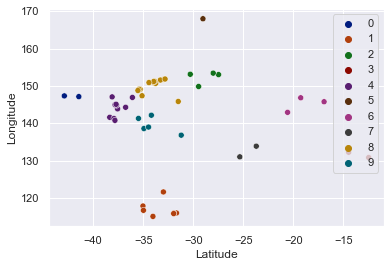

In [144]:
### uso Kmeans para clusterizar las ciudades.
X=df_locations.drop("City", axis=1)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
sns.scatterplot(x="Latitude", y="Longitude", data=df_locations, hue=kmeans.labels_, palette="dark")
### joineo los labels a df_locations
df_locations = pd.concat([df_locations, pd.DataFrame(data=kmeans.labels_, columns=["Cluster"])], axis=1, join="inner")

In [145]:
for city in cities:
    df=df.replace(to_replace=city, value=str(np.array(df_locations.loc[df_locations.City==city]["Cluster"])))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindGustDir_W,WindGustDir_E,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir9am_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,WindDir3pm_E
0,2008-12-01,[4],13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,1,0,0,0,1,0,1,0,1,0
1,2008-12-02,[4],7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,1,0,1,0,1,0,0,1,1,0
2,2008-12-03,[4],12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,1,0,0,0,1,0,0,1,1,0
3,2008-12-04,[4],9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,0,1,0,1,0,1,0,0,0,1
4,2008-12-05,[4],17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,1,0,1,0,0,1,1,0,1,0


In [146]:
location = pd.get_dummies(df["Location"])
df= pd.concat([df, location], axis=1, join="inner")
df= df.drop("Location", axis=1)
df.shape

(145412, 46)

In [147]:
######### Divido en subsets de entrenamiento y test.
df_1 = df.sample(frac=1)
df_1 = df_1.reset_index(drop=True)
y=df_1["RainTomorrow"]
X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size=0.2, random_state=1,shuffle=False)
X_train.shape, X_test.shape

((116329, 46), (29083, 46))

In [148]:
X_train=X_train.drop(["Evaporation", "Sunshine"], axis=1)
X_train.shape

(116329, 44)

In [149]:
X_train["Amplitud_Temp"]=(X_train["MaxTemp"]-X_train["MinTemp"])

In [150]:
X_train = promedio(X_train, "Pressure9am", "Pressure3pm", "Pressure", True)
X_train=X_train.drop(["Pressure9am", "Pressure3pm"], axis=1)

In [151]:
##### Para seguir analizando relaciones entre datos es necesario ya imputar los datos faltantes
##### Comienzo por dropear Cloud9am y Cloud3pm. Tienen una cantidad de datos faltantes muy importante.
X_train=X_train.drop(["Cloud9am","Cloud3pm"],axis=1)

In [152]:
### Termino de acomodar las columnas de X_train. Saco además RainTomorrow y Rainfall_tomorrow.
X_train=X_train.drop(["Date","MinTemp","MaxTemp","Temp9am","Temp3pm"],axis=1)

In [153]:
#### no voy a imputar valores correspondientes a lluvias. De eso se encargará el modelo a entrenar.
X_train=X_train.dropna(subset=['Rainfall', 'Rainfall_tomorrow','RainToday','RainTomorrow'])
X_train.shape

(112585, 37)

In [154]:
from sklearn.impute import SimpleImputer

def impute_by_mean(X_t, column):
    X_train=X_t.copy()
    outlier_diagnostic_plots(X_train, column, 1.5)
    imputer = SimpleImputer(strategy='mean',add_indicator=True)
    X_train[column] = imputer.fit_transform(X_train[column].values.reshape(-1, 1))
    outlier_diagnostic_plots(X_train, column, 1.5)
    return X_train, imputer

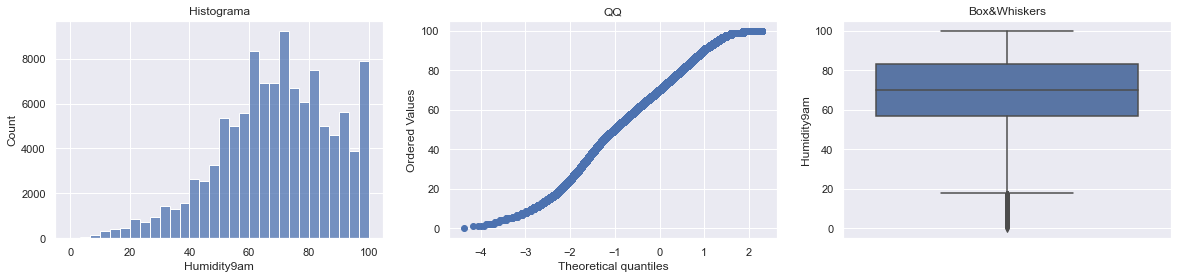

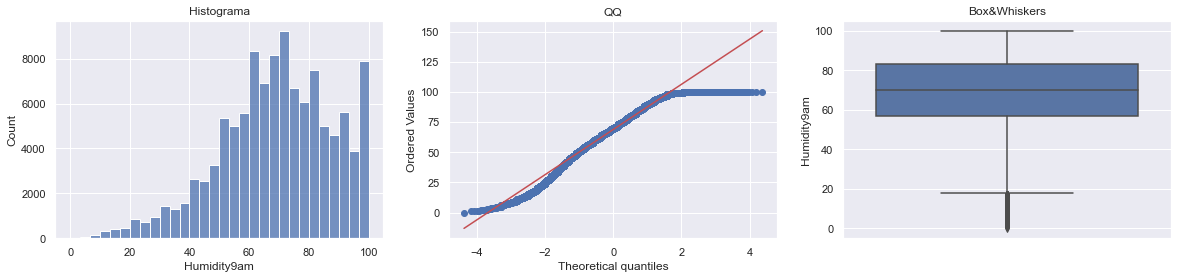

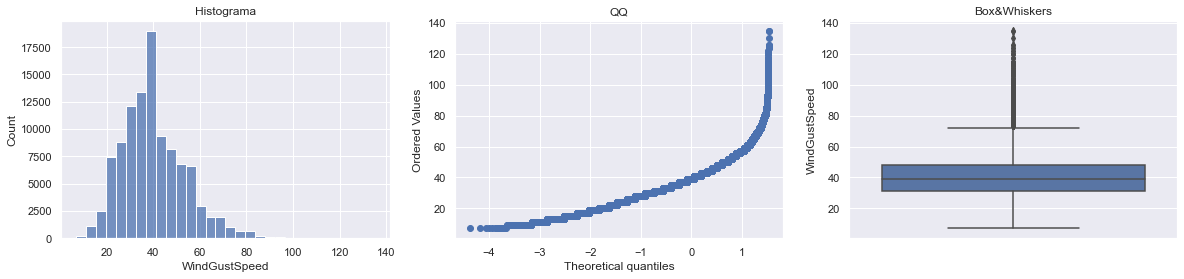

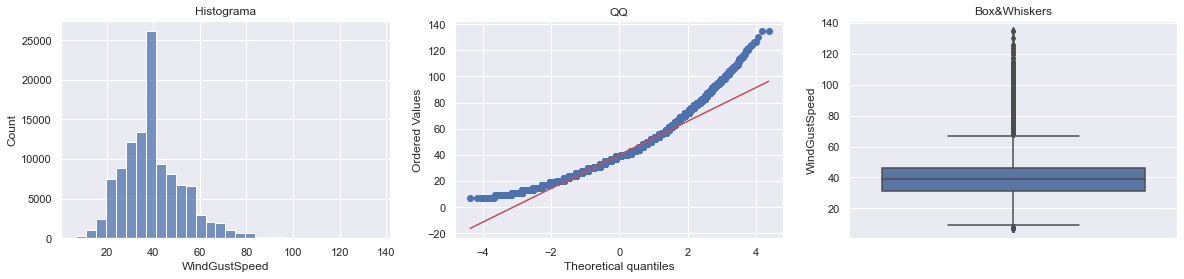

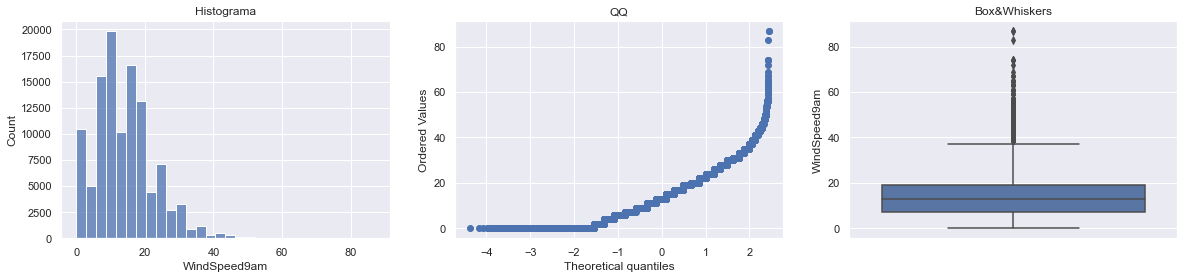

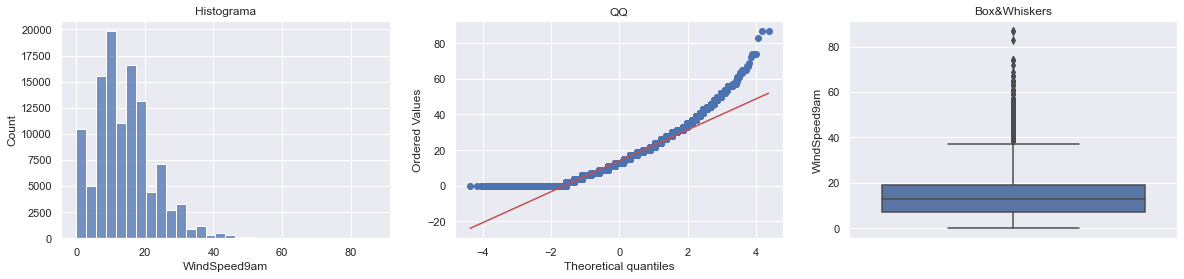

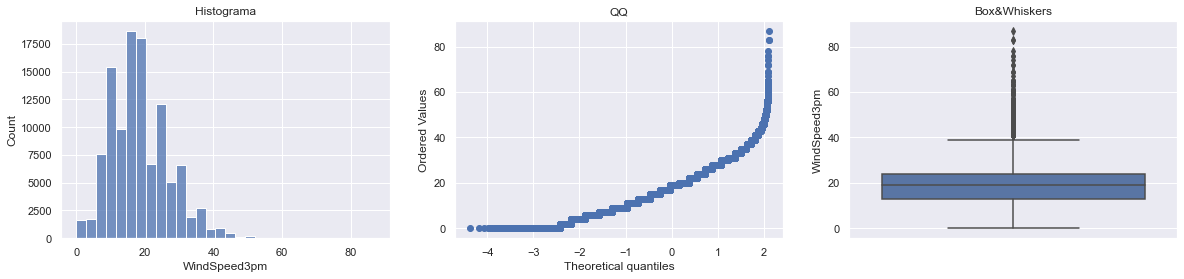

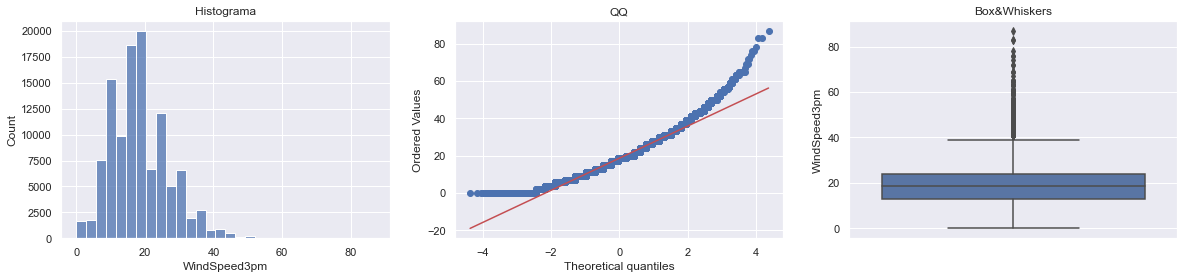

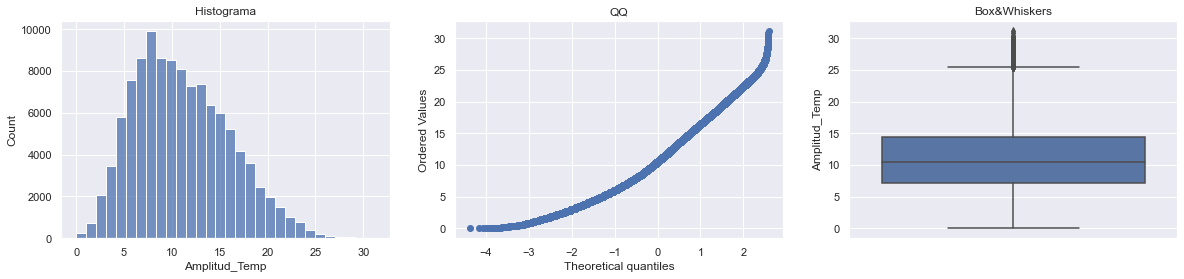

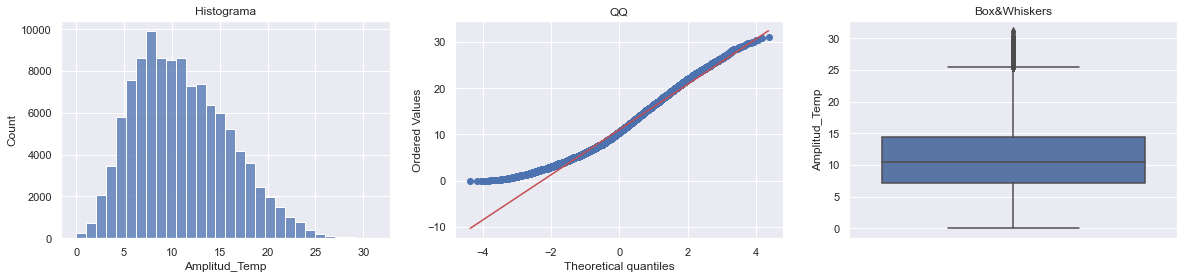

In [155]:
cols=["Humidity9am","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Amplitud_Temp"]
X_means = pd.DataFrame(columns=cols)
for column in cols:
    X_train, X_means.loc[0,column]=impute_by_mean(X_train,column)

In [156]:
###########3 IMPUTACION POR KNN
from sklearn.impute import KNNImputer
def impute_by_KNN2(X_t, n):
    X_train=X_t.copy()
    imputer = KNNImputer(n_neighbors=n)
    X_KNN = imputer.fit_transform(X_train)
    X_KNN = pd.DataFrame(data=X_KNN, columns=X_train.columns, index=X_train.index)
    return X_KNN,imputer

In [157]:
neighbors=5
Xt2, KNN_imputer=impute_by_KNN2(X_train[["Pressure","Humidity3pm","Amplitud_Temp"]],neighbors)

In [158]:
for column in ["Pressure","Humidity3pm"]:
    X_train[column]=Xt2[column]

In [159]:
y_train=X_train["RainTomorrow"]
y_train_reg=X_train["Rainfall_tomorrow"]
X_train=X_train.drop(["RainTomorrow","Rainfall_tomorrow"],axis=1)

In [31]:
from sklearn.feature_selection import mutual_info_regression

MI = mutual_info_regression(X_train, y_train_reg)
MI = pd.DataFrame(data=100*MI,index=X_train.columns)
MI

,0
Rainfall,9.489960
WindGustSpeed,3.043880
WindSpeed9am,0.682926
WindSpeed3pm,0.737568
Humidity9am,6.674814
Humidity3pm,16.266685
RainToday,6.283674
Verano,0.517809
Otoño,0.251789
Invierno,0.417690


In [160]:
def poner_a_tono(df):
    df["Amplitud_Temp"]=df["MaxTemp"]-df["MinTemp"]
    df=promedio(df, "Pressure9am", "Pressure3pm", "Pressure", True)
    cols_to_drop=["Date","MinTemp","MaxTemp","Cloud9am","Cloud3pm","Temp9am","Temp3pm","Pressure3pm","Pressure9am", "Evaporation","Sunshine"]
    df=df.drop(cols_to_drop, axis=1)
    #### empezamos a ver los NaNs.
    df=df.dropna(subset=['Rainfall', 'Rainfall_tomorrow','RainToday','RainTomorrow'])
     ## imputaciones por mediana
    for col in ["Humidity9am","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Amplitud_Temp"]:
        df[col] = X_means.loc[0,col].transform(df[col].values.reshape(-1,1))
    ### imputaciones por KNN
    df2=KNN_imputer.transform(df[["Pressure","Humidity3pm","Amplitud_Temp"]])
    df.loc[:,"Pressure"]=df2[:,0]
    df.loc[:,"Humidity3pm"]=df2[:,1]
    
    return df   

In [161]:
X_train=X_train.drop(["Verano", "Invierno","Otoño","Primavera"], axis=1)
X_test=X_test.drop(["Verano", "Invierno","Otoño","Primavera"], axis=1)

In [162]:
X_test=poner_a_tono(X_test)

In [163]:
y_test=X_test["RainTomorrow"]
y_test_reg=X_test["Rainfall_tomorrow"]
X_test=X_test.drop(["Rainfall_tomorrow","RainTomorrow"],axis=1)

In [164]:
# Estandarizamos
scaler = RobustScaler(quantile_range=(5, 95))
scaler_y = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train_reg.values.reshape(-1,1))

In [165]:
X_train.isna().sum()

Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
RainToday        0
WindGustDir_N    0
WindGustDir_S    0
WindGustDir_W    0
WindGustDir_E    0
WindDir9am_N     0
WindDir9am_S     0
WindDir9am_W     0
WindDir9am_E     0
WindDir3pm_N     0
WindDir3pm_S     0
WindDir3pm_W     0
WindDir3pm_E     0
[0]              0
[1]              0
[2]              0
[3]              0
[4]              0
[5]              0
[6]              0
[7]              0
[8]              0
[9]              0
Amplitud_Temp    0
Pressure         0
dtype: int64

In [167]:
X_test_scaled=scaler.transform(X_test)
y_test_scaled=scaler_y.transform(y_test_reg.values.reshape(-1,1))

In [168]:
lin_reg = LinearRegression().fit(X_scaled, y_scaled)

In [169]:
coef = pd.DataFrame(data=lin_reg.coef_, columns=X_train.columns)
coef

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,RainToday,WindGustDir_N,WindGustDir_S,WindGustDir_W,...,[2],[3],[4],[5],[6],[7],[8],[9],Amplitud_Temp,Pressure
0,0.007271,0.015065,-0.000477,-0.00686,-0.000877,0.026809,0.000019,0.000714,0.000726,-0.000839,...,6.525032e+09,6.525032e+09,6.525032e+09,6.525032e+09,6.525032e+09,6.525032e+09,6.525032e+09,6.525032e+09,0.004703,-0.005679


In [170]:
predicciones = lin_reg.predict(X_test_scaled)

In [171]:
mse=MSE()

In [172]:
train_predicciones = lin_reg.predict(X_scaled)
train_error = mse(train_predicciones, X_scaled)
train_error

7.134414562177771

In [199]:
predicciones.shape, y_test_scaled.shape

((28162, 1), (28162, 1))

In [173]:
error=mse(predicciones, y_test_scaled)

In [174]:
error

0.0003901272787719512

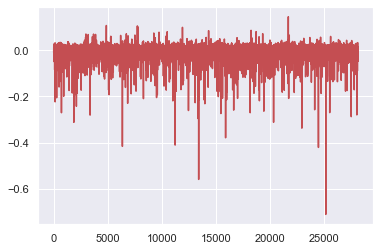

In [175]:
rn = np.linspace(0, len(y_test_scaled),len(y_test_scaled))
plt.plot(rn, predicciones - y_test_scaled, 'r')
#plt.plot(rn, predicciones, 'y')
plt.show()

In [176]:
y_pred_real = scaler_y.inverse_transform(predicciones)

In [196]:
np.array(y_test_reg).shape

(28162,)

In [201]:
y_test_reg.values.reshape(-1,1) - y_pred_real

array([[ 3.63561115],
       [-2.31252289],
       [-0.33647633],
       ...,
       [17.63627758],
       [ 0.35828362],
       [ 1.57799644]])

In [198]:
dif.shape

(28162, 28162)

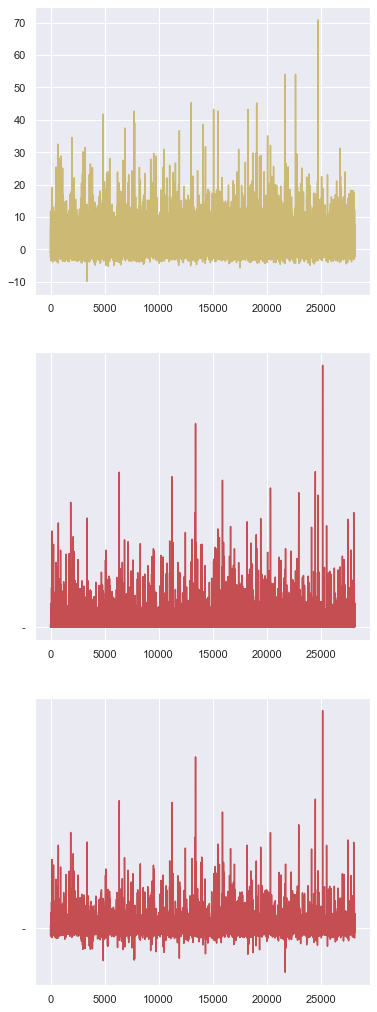

In [203]:
fig, ax = plt.subplots(3, 1, figsize=(6,18))
rn = np.linspace(0, len(y_test_scaled),len(y_test_scaled))
ax[0].plot(rn, y_pred_real, 'y')
ax[1].plot(rn, y_test_reg, 'r', '-')
ax[2].plot(rn, y_test_reg.values.reshape(-1,1) - y_pred_real, 'r', '-')
plt.show()

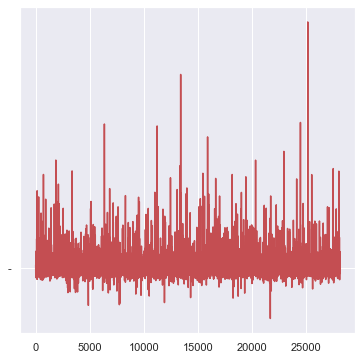

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
rn = np.linspace(0, len(y_test_scaled),len(y_test_scaled))
ax.plot(rn, y_test_reg.values.reshape(-1,1) - y_pred_real, 'r', '-')
plt.show()

array([[0.00700809],
       [0.        ],
       [0.        ],
       ...,
       [0.06846361],
       [0.00026954],
       [0.00592992]])